In [152]:
import matplotlib 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

Since the posterior density $p(x|a) = N(a)e^{\frac{-x^2}{2a}}$, and the normalization 
$$\int p(x|a) dx = \int N(a)e^{\frac{-x^2}{2a}} =1.$$
One has $\int N(a)e^{\frac{-x^2}{2a}} dx = N(a)\sqrt{2\pi a}=1$, thus $N(a)=1/\sqrt{2\pi a}$.

In [2]:
# Define a function to generate the gaussain random sample

def gen_gaussian_sample(mean=0, std=1, N=100):
    '''
    Returns a sample of gaussian distributions

    Parameters:
    -----------
    mean: float
        the mean of the gaussian
    std: float
        standard deviation of the gaussian
    N: int
        number of sample
    
    Returns: 1D array
    '''

    return np.random.normal(loc=mean, scale=std, size=N)

Due to the uniform prior of a, $p(a|\{x\}) \propto p(\{x\}|a)$.
$$p(\{x\}|a) = \prod_{i=1}^{n}p(x_i|a)=\left[N(a)\right]^n exp(-\sum_{i,j}x_iC^{-1}_{ij}x_j/2).$$
In this problem, the samples are independetly drawn from the Gaussain, thus $C=diag\{a,a,a,...,a\}$.
Thus, $$p(a|\{x\}) \propto p(\{x\}|a) =\left(2\pi a\right)^{-n/2} exp(-\sum_{i=1}^nx_i^2/2a).$$

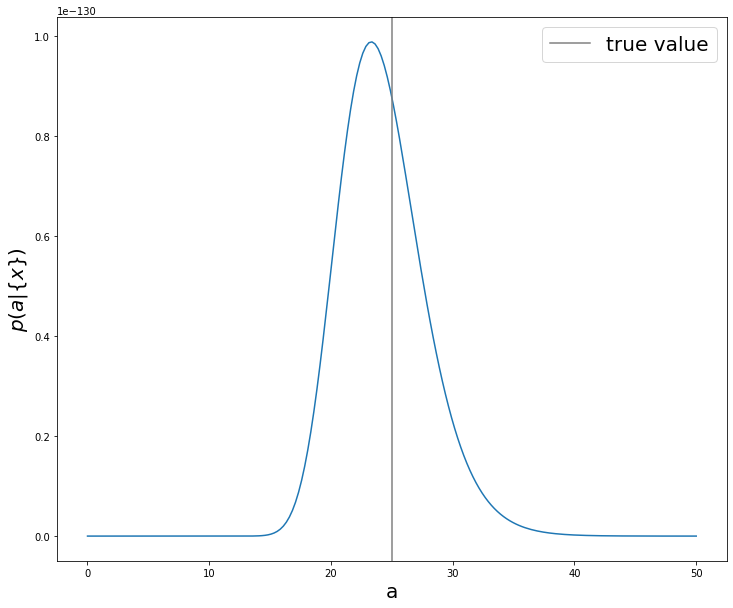

In [155]:
def get_likelihood(data, mean=0, var=1):
    ''' 
    Returns the likelihood of the data array assume a gaussian likelihood

    Parameters:
    -----------
    data: 1D array
        the data vector
    mean: float
        the mean of the gaussian likelihood
    var: float
        variance of the gaussian likelihood
    
    Returns: float
        likelihood of the data under the gaussian likelihood model
    '''

    if var <= 0:
        raise ValueError("input variance must be a positive real number")

    num = len(data)
    return np.power(2*np.pi*var, -num/2)*np.exp(-np.sum((data-mean)**2)/2/var)

sample = gen_gaussian_sample(std=5)
a = np.linspace(0.01, 50, 200)
likelihood = list(map(lambda x: get_likelihood(sample, 0, x), a))

plt.figure(figsize=(12,10))
plt.plot(a, likelihood)
plt.axvline(x=25, color='grey', label='true value')
plt.legend(fontsize=20)
plt.xlabel('a', fontsize=20)
plt.ylabel(r'$p(a|\{x\})$', fontsize=20)
plt.show()

In [156]:
class mcmc_mh(object):
    '''
    MCMC runner
    '''

    def __init__(self, data, init=1, scale_prop=1):
        '''
        Initialize the MCMC runner

        Parameters:
        ----------
        N_steps: int
            number of steps to run for the MCMC runner
        init: float
            starting point of the chain
        scale_prop: float
            the scale of the generator
        
        Attrbutes:
        ---------
        data: 1D array
            the observational data
        chain: 1D array
            record of the parameter value of the chain
        posterior: 1D array
            record of the posterior in each step
        scale_prop: float
            the std of the generator
        _length: int
            length of the data vector
        '''

        if init <= 0:
            raise ValueError("input initial variance must be a positive real number")

        self._length = len(data)
        self.data = data
        self.chain = [init]
        self.posterior = [self.get_posterior()]
        self.scale_prop = scale_prop
    
    def get_posterior(self, var=None):
        '''
        get posterior

        Parameters: 
        -----------
        var: float
            variance (the free parameter) of likelihood
            If None, use the last one stored in the chain
        
        Returns: float
            the posterior
        '''
        if (var is None):
            var = self.chain[-1]
        if var<=0:
            # make sure that the variance only explore positive real space
            return -np.inf
        else:
            return np.power(2*np.pi*var, -self._length/2)*np.exp(-np.sum((self.data)**2)/2/var)
    
    def generator(self, scale_prop=None):
        '''
        generator function to propose the next 

        Parameters: 
        -----------
        scale_prop: float
            scale of the generator function
            If None, use the default scale
        
        Returns: float
            the proposed next step 
        '''

        if (scale_prop is not None):
            self.scale_prop = scale_prop
        
        return self.chain[-1]+np.random.normal(scale = np.sqrt(self.scale_prop))
    
    def get_pacc(self, p_new):
        '''
        get the probability of acceptance

        Parameters: 
        -----------
        p_new: float
            the posterior of the new point
        
        Returns: float
            the probability of the acceptance
        '''
        return min(1, p_new/self.posterior[-1])
    
    def runner(self, scale_prop=None, Nsteps=5000):
        '''
        MCMC runner

        Parameters: 
        -----------
        scale_prop: float
            scale of the generator function
            If None, use the default scale
        Nsteps: int
            Number of MCMC steps
        
        '''
        if (scale_prop is not None):
            new = self.generator(scale_prop=scale_prop)
        else:
            new = self.generator()
        
        for _ in range(Nsteps):
            # get the probability of newly proposed value 
            post_new = self.get_posterior(var = new)

            # get the probability of acceptance
            p_acc = self.get_pacc(post_new)

            # generate a random number from U(0,1)
            temp = np.random.uniform()
            # accept the newly proposed point if temp < p_acc
            accept = (temp < p_acc)

            # update the chain and posterior according to the acceptance
            if accept:
                self.chain.append(new)
                self.posterior.append(post_new)
            else: 
                self.chain.append(self.chain[-1])
                self.posterior.append(self.posterior[-1])
            
            # generate the next point
            if (scale_prop is not None):
                new = self.generator(scale_prop=scale_prop)
            else:
                new = self.generator()

In [157]:
test = mcmc_mh(sample, init=100)
test.runner(scale_prop=3, Nsteps=6000)

Text(0, 0.5, 'a')

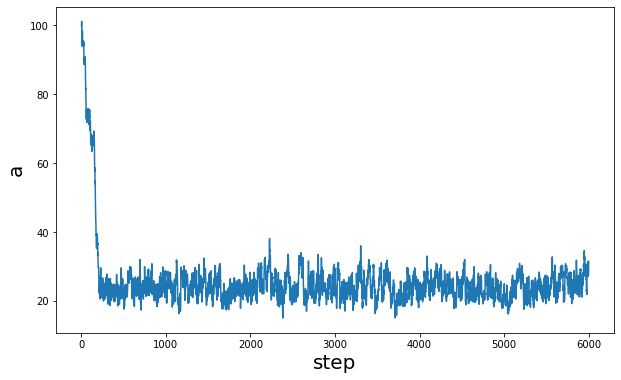

In [158]:
# Plot the trace

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, len(test.chain), len(test.chain)), test.chain)
plt.xlabel('step', fontsize=20)
plt.ylabel('a', fontsize=20)

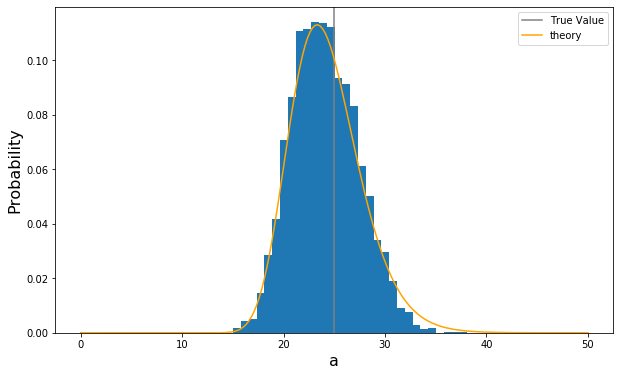

In [168]:
# plot posterior from the chain anc compare with the theory posterior

plt.figure(figsize=(10,6))

plt.hist(test.chain[500:], density=True, bins=30)
plt.axvline(x=25, color='grey', label='True Value')

# 3.8 here is to properly scale the theory posterior, since the posterior is not properly normalized in the previous sections
plt.plot(a, 3.8*np.array((likelihood/sum(likelihood))), color='orange', label='theory')

plt.legend()
plt.xlabel('a', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.show()